# Classification

In this demo we are going to build a simple network to do binary classification, we will generate the test data ourselves using the [sklearn](https://scikit-learn.org/stable/index.html) library then we will train the network to classify the data.

## Getting started

We are going to start by importing our base libraries and setting the random seed for reproducibility. 

In [1]:
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib
import torch.optim as optim

## Data generation

We will use the  ```make_circles``` function from the ```sklearn.datasets``` module to generate our data. This function generates a large circle containing a smaller circle in 2D. A simple toy dataset to visualize clustering and classification algorithms.

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
x, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42,  # a little bit of noise to the dots
)  # keep random state so we get the same values

print(x.shape, y.shape)
print(type(x), type(y))
print(x[:10], y[:10])

(1000, 2) (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]] [1 1 1 1 0 1 1 1 1 0]


You can see that the data has two components, the first one is the data itself as x,y co-ordinates and the second one is the labels. We will use the data to train our network and the labels to evaluate it.

We can plot this to see the data in full. 

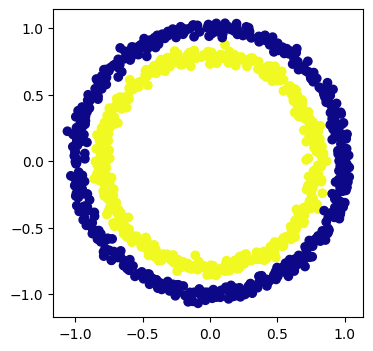

In [3]:
plt.figure(figsize=(4, 4))

plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap=plt.cm.plasma);

You will notice we are using a colourmap here for more details on colourmaps see the [matplotlib documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html) and to see all the colourmaps use ```list(matplotlib.colormaps)``` in your python console.

## Data Preprocessing

We now need to convert our data into tensors and generate our test / train split. We will use the typical 80:20 split for this.

In [4]:
X = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

train_split = int(0.8 * len(X))
X_train = X[:train_split]
X_test = X[train_split:]

y_train = y[:train_split]
y_test = y[train_split:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


## Building a Model

We are going to build a simple model and in this case we will also use the GPU if it is available. To do this we will use the get_device function outlined in the lab. This will make the code work across different devices.

In [5]:
def get_device() -> torch.device:
    """
    Returns the appropriate device for the current environment.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():  # mac metal backend
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Make device agnostic code
device = get_device()
print(device)

mps


We are going to use the same linear model we used in the previous lab. We will use the ```nn.Linear``` class to create a linear layer rather than constructing it ourselves. We will still inherit from nn.Module and use the super() function to initialise the parent class.

We will then define the forward function to pass the data through the model.

In [6]:
class BinaryClassify(nn.Module):
    def __init__(self):
        super().__init__()
        # layer 1 has 2 inputs and 5 outputs (hidden layer)
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # layer 2 has 5 inputs and 1 output (is it label 0 or 1)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # as we have nn.Linear layers, we can use them directly in forward as they
    # are callable objects able to perform the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model = BinaryClassify().to(device)
print(model.parameters)
print(model.state_dict())

<bound method Module.parameters of BinaryClassify(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)>
OrderedDict({'layer_1.weight': tensor([[ 0.5785, -0.4385],
        [-0.5394,  0.1798],
        [ 0.5827,  0.1937],
        [-0.5464, -0.6197],
        [-0.1385,  0.7052]], device='mps:0'), 'layer_1.bias': tensor([-0.2372,  0.1316, -0.3317,  0.1426, -0.6505], device='mps:0'), 'layer_2.weight': tensor([[ 0.1068, -0.2311,  0.1028,  0.1930, -0.4170]], device='mps:0'), 'layer_2.bias': tensor([-0.4322], device='mps:0')})


You will notice that we are taking an input with 2 features and expanding it to 5 features. This is a common technique in neural networks to allow the model to learn more complex patterns (this does not always work and can lead to overfitting). This is a hyperparameter and can be tuned to improve the model.

It is important that the next layer has the same number of features as the previous layer has output. This is why the next layer has 5 input features.

## Using nn.Sequential

This mode of building a model is fine for simple models but can become cumbersome for more complex models. PyTorch provides the ```nn.Sequential``` class to allow us to build models more easily. We can pass the layers as arguments to the ```nn.Sequential``` class and it will build the model for us. 

The model above can be built using ```nn.Sequential``` as follows:


In [7]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)
).to(device)

print(model.parameters)
print(model.state_dict())

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)>
OrderedDict({'0.weight': tensor([[-0.5751, -0.4116],
        [ 0.5101, -0.1699],
        [-0.6411,  0.1390],
        [-0.5822, -0.3268],
        [-0.3986, -0.2849]], device='mps:0'), '0.bias': tensor([-0.1792, -0.4250, -0.4238,  0.1485,  0.6357], device='mps:0'), '1.weight': tensor([[-0.1280,  0.2797, -0.3037,  0.3193,  0.2608]], device='mps:0'), '1.bias': tensor([-0.1119], device='mps:0')})


We will use this model (basically forward is written for us now) this is really easy and for simple tasks ideal. However for more complex models we will need to use the more manual method and define our own forward function.

We can now see what our untrained model does.

In [8]:
prediction = model(X_test.to(device))
print(f"Length of predictions: {len(prediction)}, Shape: {prediction.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{prediction[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0998],
        [ 0.2910],
        [ 0.0371],
        [ 0.1485],
        [ 0.0143],
        [-0.0110],
        [-0.0508],
        [-0.1162],
        [ 0.1859],
        [ 0.1484]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.])


note the output is in the form of a tensor (and has negative values) not the binary output we want. We will need to convert this to a binary output but we will train our model first. 

## Loss Function and Optimizer

As we are dealing with a binary classification problem we can choose a suitable function from the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#loss-functions). 

PyTorch has two 
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) 
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

They are both similar however the BCEWithLogitsLoss is more numerically stable and has a built in sigmoid function.

We will use the Stochastic Gradient Descent (SGD) optimizer to train our model as in the previous lab.

In [9]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(params=model.parameters(), lr=0.1)

Next we need to see how close our function is to the actual labels we can generate a function to do this this is know as an evaluation function and is basically the opposite of the loss function but it can sometimes be more useful to see how well the model is doing.


In [10]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Training the Model

We will now train the model using the training data. We will use the same training loop as in the previous lab but using the new data sets, we will now also copy the data to the device to help speed up the training process.

In [11]:
torch.manual_seed(42)

epochs = 100

# copy to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    # turn logits -> pred probs -> pred labls
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred)

    # reset the optimizer to zero
    optimizer.zero_grad()
    # calculate the gradients
    loss.backward()
    # update the weights
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69752, Accuracy: 52.00% | Test loss: 0.70250, Test acc: 54.00%
Epoch: 10 | Loss: 0.69560, Accuracy: 51.25% | Test loss: 0.70135, Test acc: 53.50%
Epoch: 20 | Loss: 0.69480, Accuracy: 51.50% | Test loss: 0.70103, Test acc: 50.50%
Epoch: 30 | Loss: 0.69438, Accuracy: 50.50% | Test loss: 0.70094, Test acc: 49.00%
Epoch: 40 | Loss: 0.69412, Accuracy: 50.75% | Test loss: 0.70091, Test acc: 48.00%
Epoch: 50 | Loss: 0.69392, Accuracy: 50.75% | Test loss: 0.70089, Test acc: 48.50%
Epoch: 60 | Loss: 0.69376, Accuracy: 50.38% | Test loss: 0.70086, Test acc: 49.00%
Epoch: 70 | Loss: 0.69362, Accuracy: 50.38% | Test loss: 0.70082, Test acc: 49.00%
Epoch: 80 | Loss: 0.69350, Accuracy: 50.75% | Test loss: 0.70078, Test acc: 48.00%
Epoch: 90 | Loss: 0.69339, Accuracy: 50.38% | Test loss: 0.70073, Test acc: 47.00%


As you can see from this result the model is not very good but what has happened?  
## Plotting the Decision Boundary

We can plot the decision boundary by generating a meshgrid of points and passing them through the model. We can then plot the result using the contourf function from matplotlib.

The code below does the following.

1. `x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1` calculates the minimum and maximum values for the first feature (column) of the dataset `X`, adding a small margin of 0.1 to both ends. This ensures that the grid will extend slightly beyond the range of the data.

2. `y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1` this line calculates the minimum and maximum values for the second feature of the dataset `X`, also adding a margin of 0.1.

3. `xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))`  This line creates a meshgrid using `numpy`. It generates two 2D arrays (`xx` and `yy`) that represent all combinations of x and y values within the specified ranges. The `np.linspace` function creates 100 evenly spaced values between `x_min` and `x_max`, and between `y_min` and `y_max`.

This will then allow us to plot into this grid to get the values we need. 

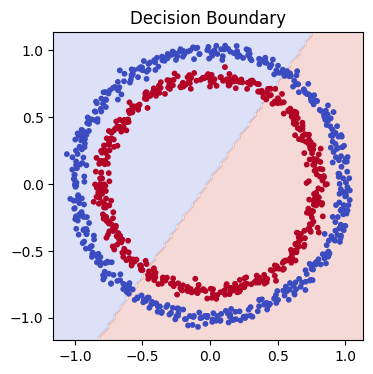

In [12]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
plt.figure(figsize=(4, 4))
grid = np.c_[xx.ravel(), yy.ravel()]
# turn the grid into a tensor
grid_tensor = torch.from_numpy(grid).type(torch.float).to(device)
# make predictions on the grid
model.eval()
with torch.inference_mode():
    test_logits = model(grid_tensor).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # reshape the predictions back into the meshgrid shape
    zz = test_preds.reshape(xx.shape).detach().cpu().numpy()
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.2)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, s=10, cmap=plt.cm.coolwarm)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Decision Boundary")
    plt.show()

As we can see using the linear model to classify non-linear data doesn't work that well and at best we can cut the data in half hence the 50% accuracy. 

This is know as underfitting as it can't (at present) learn any patterns from this data.

# Conclusion

We have built a simple neural network to classify data generated by sklearn. We have seen that a linear model is not suitable for this data and we will need to use a more complex model to classify this data. We have also seen how to use the nn.Sequential class to build models more easily.

In the next lab we will build a more complex model to classify this data.

# References

1. https://scikit-learn.org/stable/index.html
2. https://matplotlib.org/stable/tutorials/colors/colormaps.html
3. https://pytorch.org/docs/stable/nn.html#loss-functions
4. https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
5. https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
6. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
7. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
8. https://pytorch.org/docs/stable/generated/torch.nn.Module.html
9. https://pytorch.org/docs/stable/generated/torch.optim.SGD.html